In [2]:
%pylab inline
import pandas as pd
import datetime
from scipy import stats
from datetime import timedelta

Populating the interactive namespace from numpy and matplotlib


Loading data about yellow taxi and about regions

In [3]:
tripdata = pd.read_csv("yellow_tripdata_2016-05.csv",",", 
                       parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
regions = pd.read_csv("regions.csv",";")

In [5]:
tripdata.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


Stripping off trips with:
    - zero distance
    - zero amount of passengers
    - same pickup/fropoff time
    - outside NY square GPS coordinates

In [8]:
LonFrom = -74.25559
LonTo = -73.70001
LatFrom = 40.49612
LatTo = 40.91553
tripdata = tripdata[(tripdata['trip_distance'] != 0) & 
          (tripdata['passenger_count'] != 0) &
          (tripdata['tpep_pickup_datetime'] != tripdata['tpep_dropoff_datetime']) &
          (tripdata['pickup_longitude'] > LonFrom) &
          (tripdata['pickup_longitude'] < LonTo) &
          (tripdata['pickup_latitude'] > LatFrom) &
          (tripdata['pickup_latitude'] < LatTo)]

Function that receives two arrays with longitude/latitude and returns the array of bins

In [9]:
def getRegion (longitude, latitude):
    binsX = np.linspace(LonFrom, LonTo, 51)
    binsY = np.linspace(LatFrom, LatTo, 51)
    reg = stats.binned_statistic_2d(longitude, latitude, None, 
                                              statistic = "count", bins = [binsX, binsY], expand_binnumbers=True)
    return (reg.binnumber[0] - 1) * 50 + reg.binnumber[1]

Adding the column with regions to the Dataframe

In [10]:
tripdata['region'] = getRegion(tripdata.pickup_longitude, tripdata.pickup_latitude)

/anaconda2/lib/python2.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [9]:
tripdata.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,region
0,1,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80,1233
1,2,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68,1180
2,2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36,1180
3,2,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96,1173
4,2,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76,1130


Rounding tpep_pickup_datetime to hours

In [11]:
%%time
tripdata.loc[:,'tpep_pickup_datetime'] = tripdata.tpep_pickup_datetime.dt.floor('h')

CPU times: user 1.97 s, sys: 752 ms, total: 2.73 s
Wall time: 798 ms


Building a new Dataframe that groups records of "tripdata" dataframe by "tpep_pickup_datetime" and "region" fields. Showing number of entries for each row.

In [12]:
tripdata_grouped = tripdata.groupby(['tpep_pickup_datetime', 'region']).size().reset_index(name='counts')
tripdata_grouped = tripdata_grouped.set_index('tpep_pickup_datetime')

In [60]:
tripdata_grouped.tail()

,region,counts
tpep_pickup_datetime,,
2016-05-02 02:00:00,2486,1
2016-05-10 11:00:00,2486,1
2016-05-10 14:00:00,2486,1
2016-05-12 21:00:00,2487,1
2016-05-22 20:00:00,2487,2


Visualising the number of pick ups in May 2016 from the square where Empire State Building is located

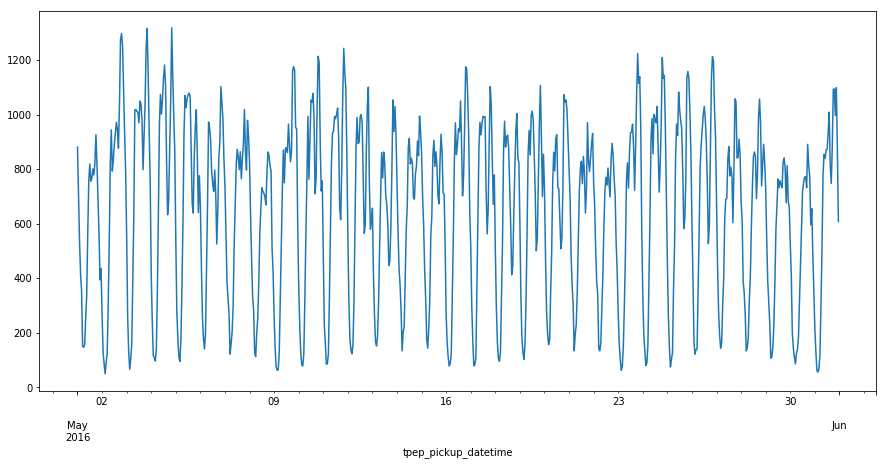

In [13]:
esb_lat = 40.748364
esb_lon = -73.985477

esb_region = getRegion ([esb_lon], [esb_lat])
esb_pickup = tripdata_grouped[tripdata_grouped["region"] == esb_region[0]]
esb_pickup = esb_pickup.set_index('tpep_pickup_datetime')

plt.figure(figsize(15,7))
esb_pickup.counts.plot()

Calculating the amount of records with 0 trips. From the total amount of combinations of hour/region (31 day * 24 hrs/day * 2500 regions) I deduct the amount of non-empty combinations

In [15]:
zero_segments = 31 * 24 * 2500 - len(tripdata_grouped)
zero_segments

1718238

Calculate zeros in more "generic" way, but more complex implementation

In [13]:
regions_range = np.arange(1, 2501)
time_range = pd.date_range(start="2016-05-01 00:00:00", end = '2016-05-31 23:00:00', freq = 'H' )
tripdata_full = pd.DataFrame()
temp_df = pd.DataFrame()

for region in regions_range:
    temp_df["tpep_pickup_datetime"] = time_range
    temp_df["region"] = region
    temp_df["counts"] = 0
    tripdata_full = tripdata_full.append(temp_df)

tripdata_full = tripdata_full.set_index('tpep_pickup_datetime')

tripdata_full = tripdata_full.sort_values(by=['region', 'tpep_pickup_datetime'])
tripdata_grouped = tripdata_grouped.sort_values(by=['region', 'tpep_pickup_datetime'])

tripdata_full_data = pd.merge_asof(tripdata_full, tripdata_grouped, on='region', 
                                                               by = ['tpep_pickup_datetime','region'])

tripdata_full_data = tripdata_full_data.fillna(0)

len(tripdata_full_data[tripdata_full_data["counts_y"] == 0])

1718238

In [14]:
tripdata_full.head()

,region,counts
tpep_pickup_datetime,,
2016-05-01 00:00:00,1,0
2016-05-01 01:00:00,1,0
2016-05-01 02:00:00,1,0
2016-05-01 03:00:00,1,0
2016-05-01 04:00:00,1,0
